In [2]:
# Step 1: Install packages you may need in Colab (Colab usually has these preinstalled,
# but pin versions for reproducibility if desired).
!pip install tensorflow scikit-learn pandas matplotlib seaborn

# Reproducibility: set seeds
import os, random
import numpy as np
import tensorflow as tf

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [21]:
# Step 2: Imports and Load Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.inspection import permutation_importance
import joblib

# Load dataset (assuming you uploaded 'data.csv' to Colab)
df = pd.read_csv("data.csv")

# Quick look at the dataset
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())


Dataset shape: (569, 33)
Columns: ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32']
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      

In [22]:
# Step 2.5: Map target and separate features/target

# Map diagnosis: M -> 1 (Malignant), B -> 0 (Benign)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Confirm mapping
print("Target value counts:\n", df['diagnosis'].value_counts())
print("Target data type:", df['diagnosis'].dtype)

# Separate features and target
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']


Target value counts:
 diagnosis
0    357
1    212
Name: count, dtype: int64
Target data type: int64


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Step 3: Handle missing values
# Impute missing values with column mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)  # Returns a numpy array

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Confirm no NaNs remain
print("Any NaNs in X_train_scaled?", np.isnan(X_train_scaled).any())
print("Any NaNs in X_test_scaled?", np.isnan(X_test_scaled).any())


Any NaNs in X_train_scaled? False
Any NaNs in X_test_scaled? False


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Unnamed: 32']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize logistic regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
log_reg.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

# Accuracy
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Testing Accuracy:", accuracy_score(y_test, y_test_pred))


Training Accuracy: 0.9868131868131869
Testing Accuracy: 0.9649122807017544



Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        72
           1       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114


Confusion Matrix:
 [[71  1]
 [ 3 39]]

ROC-AUC Score: 0.996031746031746


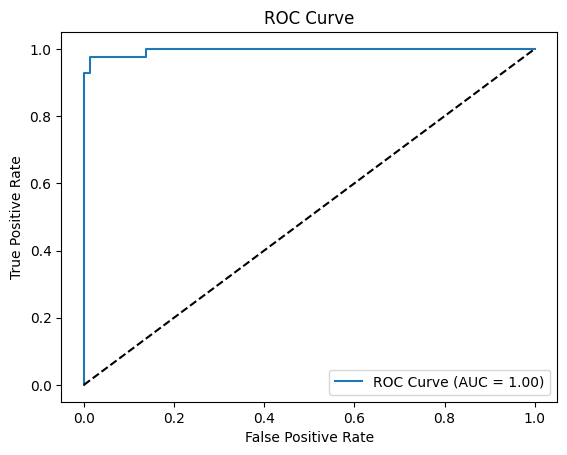

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:\n", cm)

# ROC-AUC score
y_test_proba = log_reg.predict_proba(X_test_scaled)[:, 1]
roc_auc = roc_auc_score(y_test, y_test_proba)
print("\nROC-AUC Score:", roc_auc)

# ROC Curve plot
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [28]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # l2 is standard for logistic regression
    'solver': ['lbfgs']
}

# GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy'
)

# Fit on training data
grid_search.fit(X_train_scaled, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

# Use best estimator to predict
best_log_reg = grid_search.best_estimator_
y_test_pred_best = best_log_reg.predict(X_test_scaled)
test_acc_best = accuracy_score(y_test, y_test_pred_best)
print("Test Accuracy with Best Model:", test_acc_best)


Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV Accuracy: 0.9714285714285715
Test Accuracy with Best Model: 0.9649122807017544


In [33]:
import numpy as np
import pandas as pd

# Take only the first 31 columns (to match coef length)
used_features = X.columns[:len(best_log_reg.coef_[0])]
feature_importance = np.abs(best_log_reg.coef_[0])

# Create DataFrame
feat_imp_df = pd.DataFrame({
    'Feature': used_features,
    'Importance': feature_importance
})

# Sort by importance
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)
print("Top 10 Important Features:\n", feat_imp_df.head(10))


Top 10 Important Features:
                 Feature  Importance
22        texture_worst    1.428289
11            radius_se    1.245725
29       symmetry_worst    1.050745
8   concave points_mean    0.966908
27      concavity_worst    0.914354
16       compactness_se    0.912136
14              area_se    0.906928
24           area_worst    0.893980
21         radius_worst    0.892894
7        concavity_mean    0.782857


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5981 - loss: 0.6702 - val_accuracy: 0.8791 - val_loss: 0.4780
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9395 - loss: 0.4216 - val_accuracy: 0.9231 - val_loss: 0.3108
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9250 - loss: 0.2721 - val_accuracy: 0.9451 - val_loss: 0.2192
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9561 - loss: 0.1929 - val_accuracy: 0.9451 - val_loss: 0.1729
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9534 - loss: 0.1474 - val_accuracy: 0.9560 - val_loss: 0.1497
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9656 - loss: 0.1142 - val_accuracy: 0.9560 - val_loss: 0.1360
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9627 - loss: 0.1061 - val_accuracy: 0.9560 - val_loss: 0.1269
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9704 - loss: 0.0898 - val_accuracy: 0.9560 - val_loss

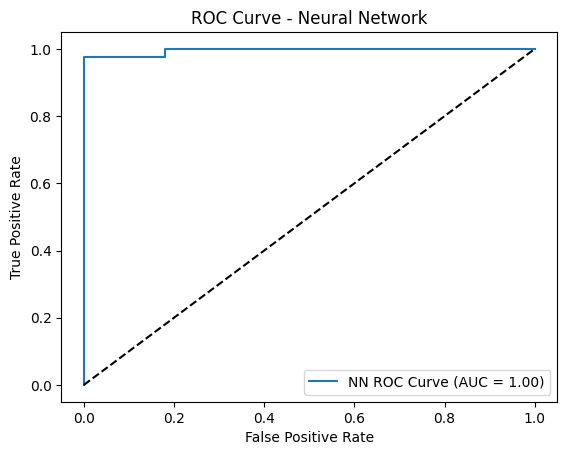

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Define the Neural Network model
nn_model = Sequential([
    Dense(32, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
nn_model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

# Train the model
history = nn_model.fit(X_train_scaled, y_train,
                       validation_split=0.2,
                       epochs=50,
                       batch_size=16,
                       verbose=1)

# Evaluate on test set
loss, accuracy = nn_model.evaluate(X_test_scaled, y_test)
print("\nNeural Network Test Accuracy:", accuracy)

# Predictions
y_test_pred_nn = (nn_model.predict(X_test_scaled) > 0.5).astype(int)

# Classification report
print("\nClassification Report (NN):")
print(classification_report(y_test, y_test_pred_nn))

# ROC-AUC
y_test_proba_nn = nn_model.predict(X_test_scaled).ravel()
roc_auc_nn = roc_auc_score(y_test, y_test_proba_nn)
print("\nROC-AUC Score (NN):", roc_auc_nn)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba_nn)
plt.plot(fpr, tpr, label=f'NN ROC Curve (AUC = {roc_auc_nn:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Network')
plt.legend()
plt.show()


In [35]:
import joblib

# Save Logistic Regression model
joblib.dump(best_log_reg, 'logistic_model.pkl')
joblib.dump(scaler, 'scaler.pkl')  # save scaler too

# Save Neural Network
nn_model.save('nn_model.h5')
